# MISS with MNIST

MISS with MNIST and MLP

> The target function is assumed to be the raw logit, i.e., $\phi(x_{\text{test}}) = \theta^\top x_{\text{test}} + b$.

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import torch
from model_train import MLP
from utlis.data import data_generation

Using device: cuda


In [2]:
# First, check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# range from 1 to 150
ks = list(range(1, 31, 4)) + [30]

# methods = ["TRAK", "Adaptive TRAK", "IF", "Adaptive IF"]
methods = ["TRAK", "Adaptive TRAK", "Influence Function", "Adaptive Influence Function"]
warm_start = True

seed = 0
ensemble_num = 5
train_size = 5000
test_size = 30
num_methods, num_experiments, num_ks = len(methods), test_size, len(ks)
TRAK_result = torch.load(f"./results/TRAK/seed_{seed}_k_{200}_ensemble_{ensemble_num}.pt")
adaptive_TRAK_result = torch.load(f"./results/TRAK/seed_{seed}_k_{200}_ensemble_{ensemble_num}_adaptive.pt")
IF_result = torch.load(f"./results/IF/seed_{seed}_k_{50}_ensemble_{ensemble_num}.pt")
adaptive_IF_result = torch.load(f"./results/IF/seed_{seed}_k_{50}_ensemble_{ensemble_num}_adaptive.pt")

Using device: cuda


In [3]:
class SubsetDataLoader:
    def __init__(self, data_loader, index):
        self.data_loader = data_loader
        self.index = index

    def __iter__(self):
        return iter([self.data_loader.dataset[self.index]])

    def __len__(self):
        return 1  # Since it contains only one data point

def actual_effect_NN(subset_remove, original_value, i_th_test, warm_start=False):
    train_loader, test_loader = data_generation([i for i in range(train_size) if i not in subset_remove], [i_th_test], mode='train')
    reduced_value = 0

    for ensemble_idx in range(ensemble_num):
        model = MLP().to(device)
        if warm_start:
            model.load_state_dict(torch.load(f"checkpoint/seed_{seed}_ensemble_{ensemble_idx}.pt"))
            epochs = 8
        else:
            epochs = 30
        model.train_with_seed(train_loader, epochs=epochs, seed=ensemble_idx, verbose=False)
        reduced_value += model.get_individual_output(test_loader)
    reduced_value /= ensemble_num
    return reduced_value - original_value

In [4]:
def score(i_th_test, k):
    original_value = 0
    scores = np.array([
        actual_effect_NN(TRAK_result[i_th_test, :k], original_value, i_th_test, warm_start).cpu().detach().numpy(),
        actual_effect_NN(adaptive_TRAK_result[i_th_test, :k], original_value, i_th_test, warm_start).cpu().detach().numpy(),
        actual_effect_NN(IF_result[i_th_test], original_value, i_th_test, warm_start).cpu().detach().numpy(),
        actual_effect_NN(adaptive_IF_result[i_th_test], original_value, i_th_test, warm_start).cpu().detach().numpy()
    ])

    return scores

In [5]:
# ranks.shape = (num_methods, num_experiments)
def Borda_count(ranks):
    # create weights based on the number of methods
    num_methods, num_experiments = ranks.shape
    weights = np.arange(num_methods, 0, -1)

    weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=float)  # Change dtype to float

    # Calculate weighted Borda count for each seed and covariance
    for experiment_idx in range(num_experiments):
        # Sort indices based on actual ranks for the current experiment
        # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
        def rankmin(x):
            u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
            csum = np.zeros_like(counts)
            csum[1:] = counts[:-1].cumsum()
            return csum[inv]

        sorted_indices = rankmin(-1 * ranks[:, experiment_idx])

        # Calculate average weight for tied ranks
        average_weights = np.zeros_like(weights, dtype=float)
        unique_sorted_indices, counts = np.unique(sorted_indices, return_counts=True)
        tie_weights = weights[np.argsort(-sorted_indices)[::-1]]

        for idx, count in zip(unique_sorted_indices, counts):
            average_weights[idx] = np.sum(tie_weights[sorted_indices == idx]) / count

        # Assign weighted Borda count scores
        for method_idx, rank in enumerate(sorted_indices):
            weighted_borda_count[method_idx, experiment_idx] = average_weights[rank]

    total_weighted_borda_count = weighted_borda_count.sum(axis=1)

    return total_weighted_borda_count

# # ranks.shape = (num_methods, num_experiments)
# def Borda_count(ranks):
#     # create weights based on the number of methods
#     num_methods, num_experiments = ranks.shape
#     weights = np.arange(num_methods, 0, -1)

#     weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=int)

#     # Calculate weighted Borda count for each seed and covariance
#     for experiment_idx in range(num_experiments):
#         # Sort indices based on actual ranks for the current experiment
#         # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
#         def rankmin(x):
#             u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
#             csum = np.zeros_like(counts)
#             csum[1:] = counts[:-1].cumsum()
#             return csum[inv]

#         sorted_indices = rankmin(-1 * ranks[:, experiment_idx])

#         # Assign weighted Borda count scores
#         for method_idx, rank in enumerate(sorted_indices):
#             weighted_borda_count[method_idx, experiment_idx] = weights[rank]

#     total_weighted_borda_count = weighted_borda_count.sum(axis=1)

#     return total_weighted_borda_count

In [6]:
scores_array = np.array(Parallel(n_jobs=20)(delayed(score)(i, k) for i in range(num_experiments) for k in ks))
scores_array = scores_array.reshape((num_experiments, num_ks, -1))

scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo

Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training

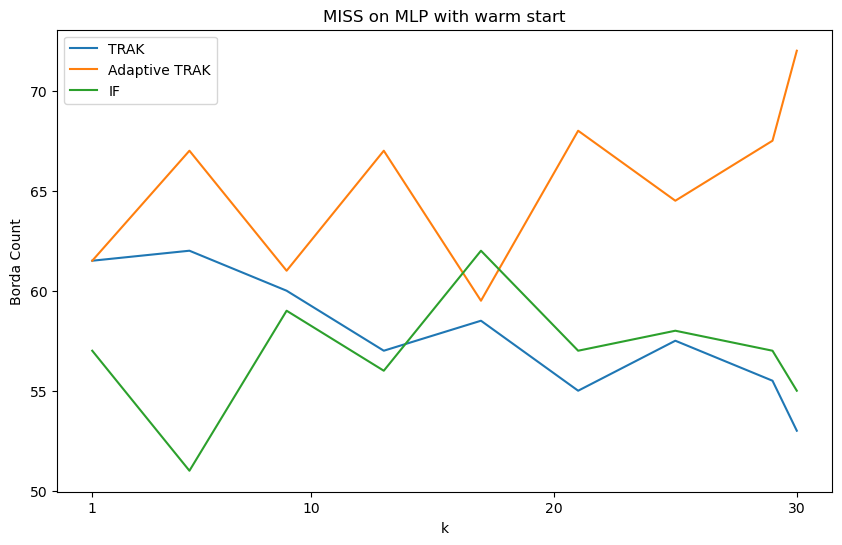

In [7]:
Borda_result = np.array(Parallel(n_jobs=20)(delayed(Borda_count)(scores_ks_method_combo[k]) for k in range(num_ks)))
plt.figure(figsize=(10, 6))  # Create a single plot

# Your data processing and plotting code here

if warm_start:
    plt.title(f'MISS on MLP with warm start')
else:
    plt.title(f'MISS on MLP with cold start')
plt.xlabel('k')
plt.ylabel('Borda Count')

# Plot each method's Borda Count against k
for method_idx, method_name in enumerate(methods):
    plt.plot(ks, Borda_result[:, method_idx], label=method_name)

plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1))

plt.legend(methods)

plt.show()

In [8]:
# # Save the Borda_result and the score_result (both are np array)
# np.save(f"results/Borda_result_{seed}_warm_{warm_start}.npy", Borda_result)
# np.save(f"results/scores_array_{seed}_warm_{warm_start}.npy", scores_array)


In [9]:
# # load score array
# scores_array = np.load(f"results/scores_array_{seed}_warm_{warm_start}.npy")
# scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
# scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo

In [1]:
# Plot scores for each method
scores_ks = scores_ks_method_combo.mean(axis=2)

plt.figure(figsize=(10, 6))  # Create a single plot

if warm_start:
    plt.title(f'MISS on MLP with warm start')
else:
    plt.title(f'MISS on MLP with cold start')
plt.xlabel('k')
plt.ylabel('Score')

for method_idx, method_name in enumerate(methods):
    plt.plot(ks, scores_ks[:, method_idx], label=method_name)

plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1))

plt.legend(methods)

plt.show()

NameError: name 'scores_ks_method_combo' is not defined